 # Materials Project Formation Energy Distribution

 MP has a curious bimodality in its formation energies. Considering the formation energies are the result of a carefully fitted correction scheme (see `pymatgen.entries.compatibility.MaterialsProject2020Compatibility`) that takes into account only the composition of a compound, let's look at which elements dominate the upper and lower modes.

 > If running this notebook on Google Colab, install the [Python 3.7 compatible release](https://github.com/janosh/pymatviz/releases/tag/v0.5.1):
 >
 > ```sh
 > !pip install pymatviz==0.5.1
 > ```

In [ ]:
import pandas as pd
import plotly.express as px
import plotly.io as pio
from pymatgen.ext.matproj import MPRester

from pymatviz import count_elements, ptable_heatmap_plotly


__author__ = "Janosh Riebesell"
__date__ = "2022-08-11"

pio.templates.default = "plotly_white"
# Interactive plotly figures don't show up on GitHub.
# https://github.com/plotly/plotly.py/issues/931
# change renderer from "svg" to "notebook" to get hover tooltips back
# (but blank plots on GitHub!)
pio.renderers.default = "png"

 Check if all of MP has a bi-modal formation energy distribution. Short answer: yes it does.

In [ ]:
MP_API_KEY = "your Materials Project API key"

e_form_col = "formation_energy_per_atom"

e_form_all_mp = MPRester(MP_API_KEY, use_document_model=False).thermo.search(
    fields=f"material_id formula_pretty {e_form_col} energy_type".split(),
    # num_elements=1,  # to test query with few results
)

df_e_form = pd.DataFrame(e_form_all_mp).set_index("material_id")
df_e_form = df_e_form.rename(columns={"formula_pretty": "formula"}).drop(columns="_id")
df_e_form

In [ ]:
# cache MP data
# %store df_e_form

# load cached MP data
# %store -r df_e_form

In [ ]:
df_e_form.energy_type.value_counts()

GGA       192347
GGA+U      83926
R2SCAN     66322
Name: energy_type, dtype: int64

In [ ]:
df_e_form_gga_only = df_e_form.query("energy_type in ('GGA', 'GGA+U')")
assert (
    len(df_e_form_gga_only) == 276_273
), f"expected 276,273 GGA & GGA+U entries, got {len(df_e_form_gga_only)}"

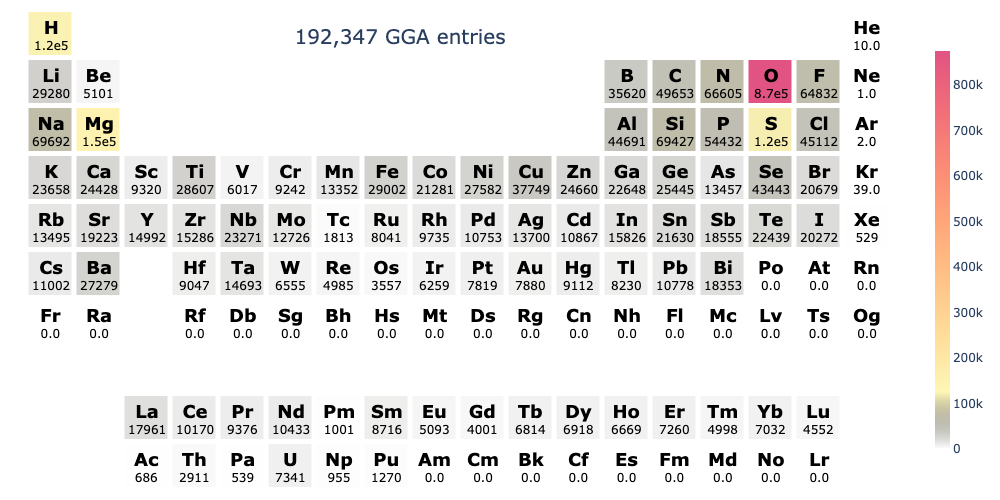

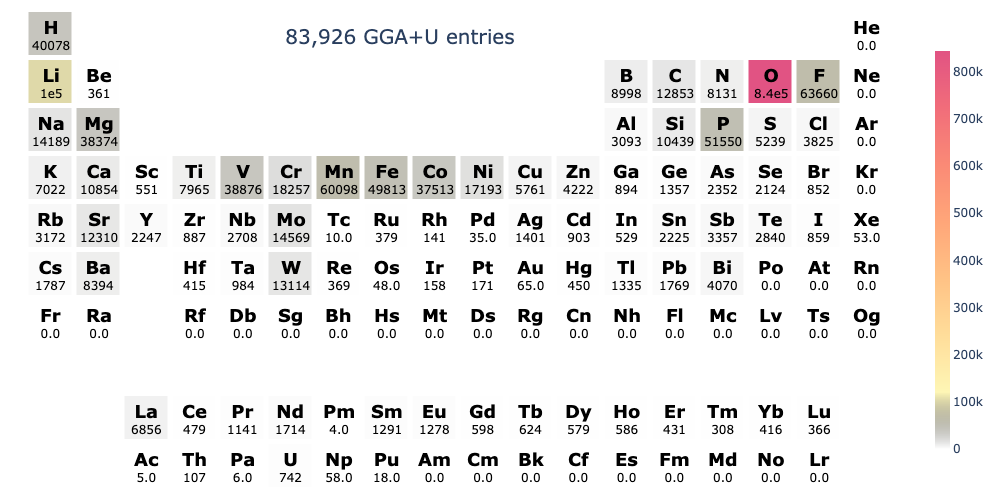

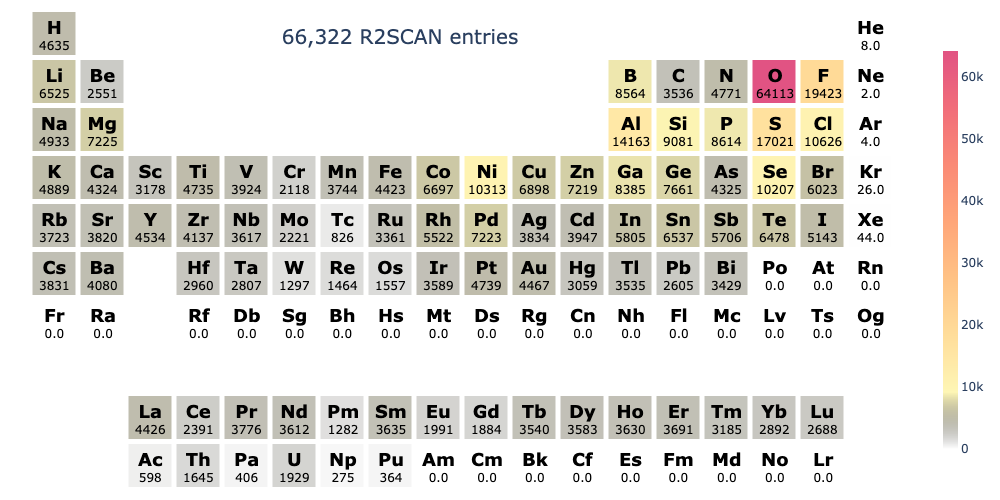

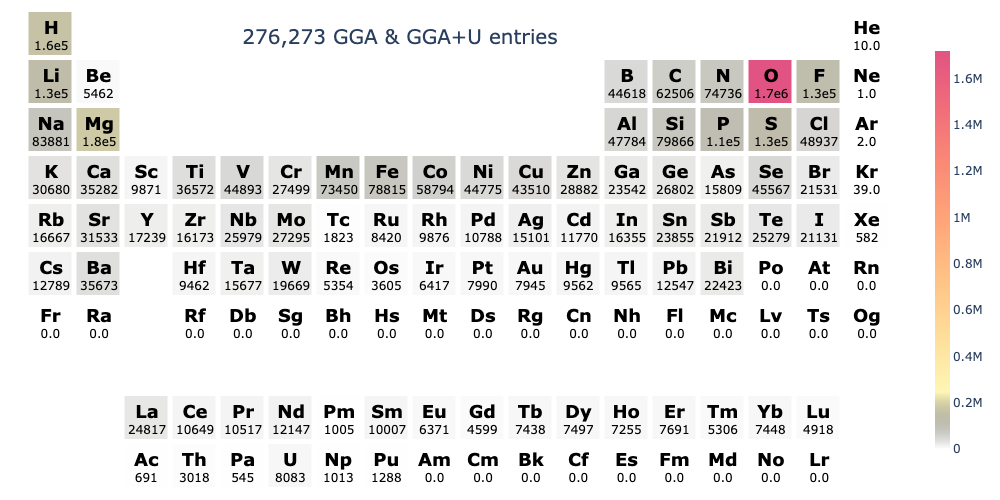

In [ ]:
for energy_type, df_e_type in [
    *df_e_form.groupby("energy_type"),
    ("GGA & GGA+U", df_e_form_gga_only),
]:
    fig = ptable_heatmap_plotly(df_e_type.formula)
    title = f"{len(df_e_type):,} {energy_type} entries"
    fig.update_layout(title=dict(text=title, x=0.4, y=0.94, font=dict(size=20)))
    fig.show()

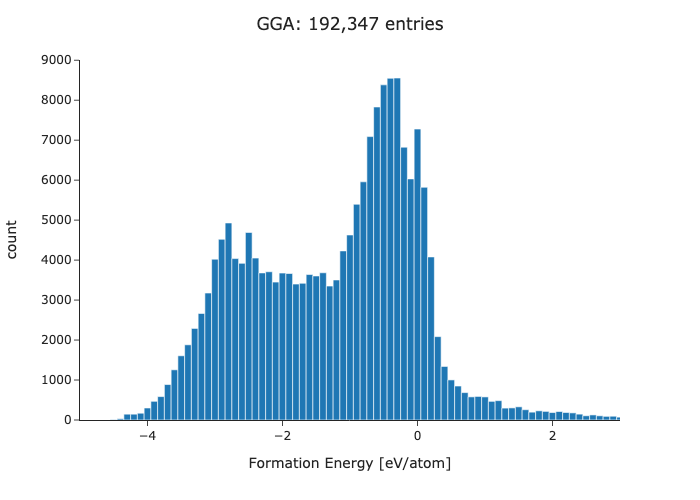

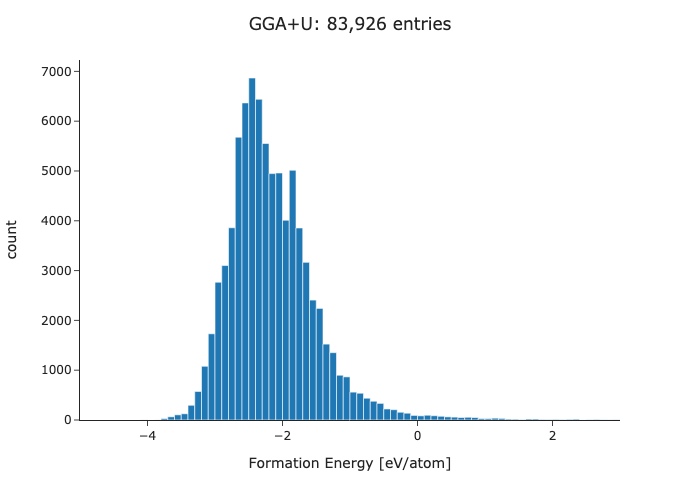

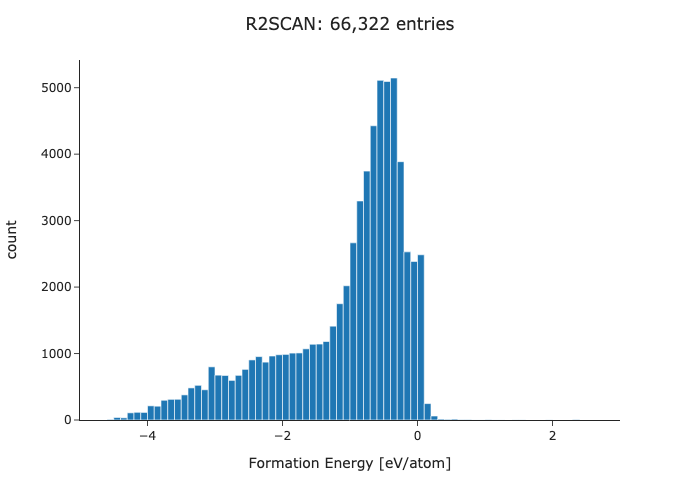

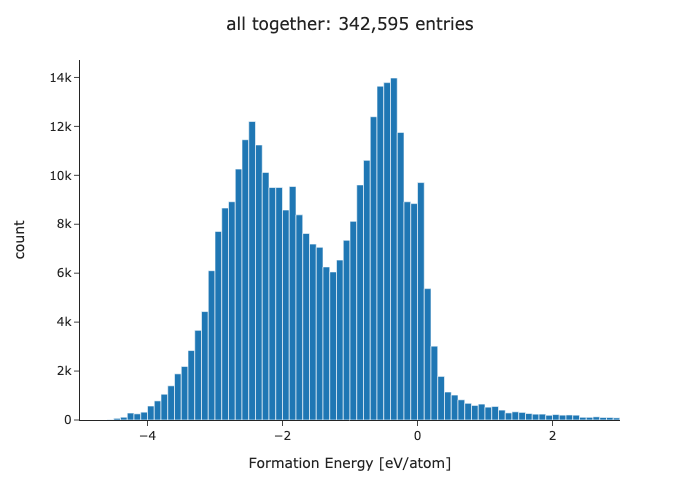

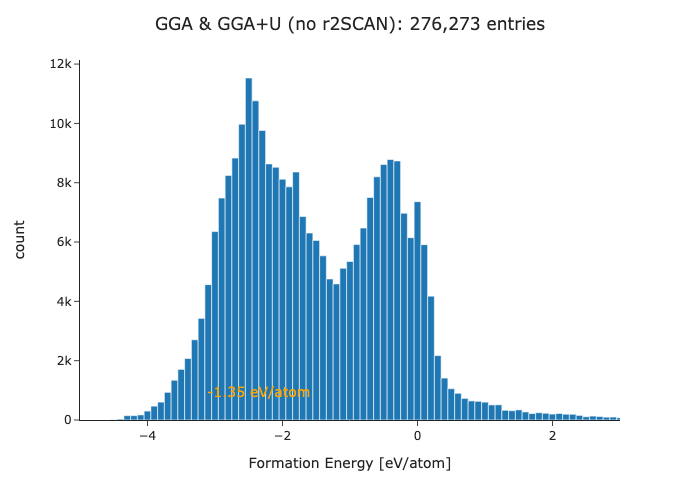

In [ ]:
labels = {
    "formation_energy_per_atom": "Formation Energy [eV/atom]",
    "count": "Number of Entries",
}
for energy_type, df_e_type in [
    *df_e_form.groupby("energy_type"),
    ["all together", df_e_form],
    ["GGA & GGA+U (no r2SCAN)", df_e_form_gga_only],
]:
    fig = px.histogram(
        df_e_type.query(f"-5 < {e_form_col} < 5"),
        x=e_form_col,
        nbins=150,
        range_x=(-5, 3),
        labels=labels,
    )
    title = f"{energy_type}: {len(df_e_type):,} entries"
    fig.update_layout(title=dict(text=title, x=0.5))

    # add vertical line at valley of GGA & GGA+U bimodal distribution
    if energy_type == "GGA & GGA+U (no r2SCAN)":
        e_form_valley = -1.35
        fig.add_vline(e_form_valley, line=dict(color="orange", dash="dash"))
        fig.add_annotation(
            text=f"{e_form_valley} eV/atom",
            x=e_form_valley - 1,
            y=0.05,
            yref="paper",
            font=dict(size=14, color="orange"),
            showarrow=False,
        )

    fig.show()

Plot element heatmap for GGA and GGA+U entries above and below `e_form_valley`.

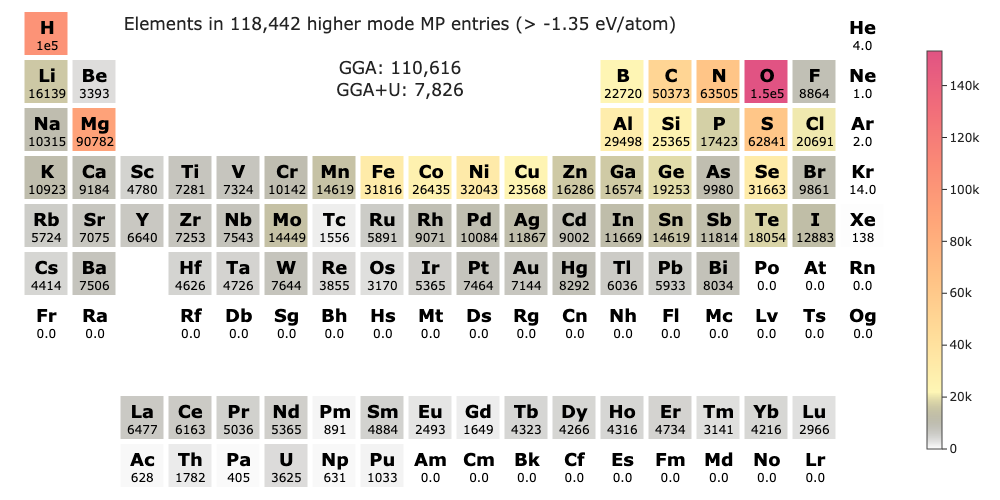

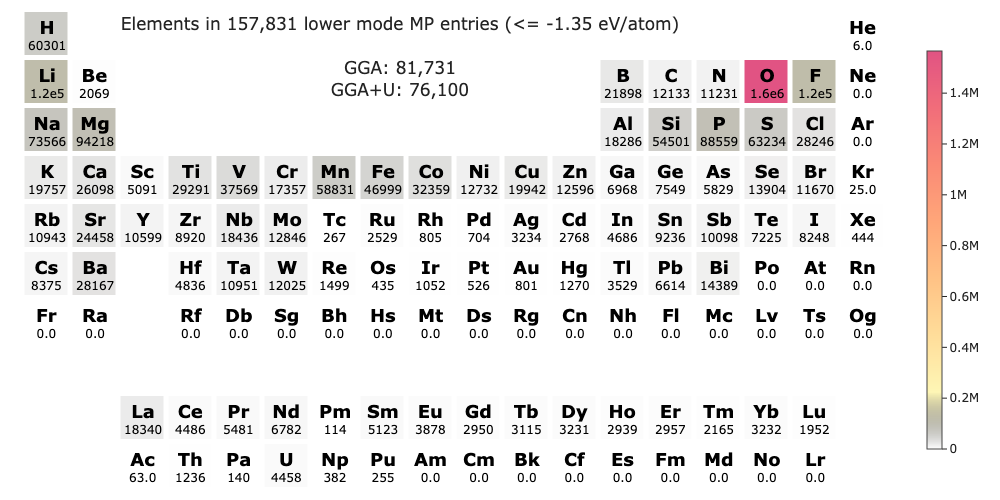

In [ ]:
for comparator, label in ((">", "higher"), ("<=", "lower")):
    df_query = df_e_form_gga_only.query(f"{e_form_col} {comparator} {e_form_valley}")
    fig = ptable_heatmap_plotly(df_query.formula)
    title = (
        f"Elements in {len(df_query):,} {label} mode MP entries "
        f"({comparator} {e_form_valley} eV/atom)<br><br>"
    )
    title += "<br>".join(
        f"{e_type}: {cnt:,}"
        for e_type, cnt in df_query.energy_type.value_counts().items()
    )

    fig.update_layout(title=dict(text=title, x=0.4, y=0.94))
    fig.show()

 Looks like the lower mode is mostly oxides, whereas the higher mode is more diverse also containing many nitrides, sulfides and selenides.

 Another way to visualize this are bar charts.

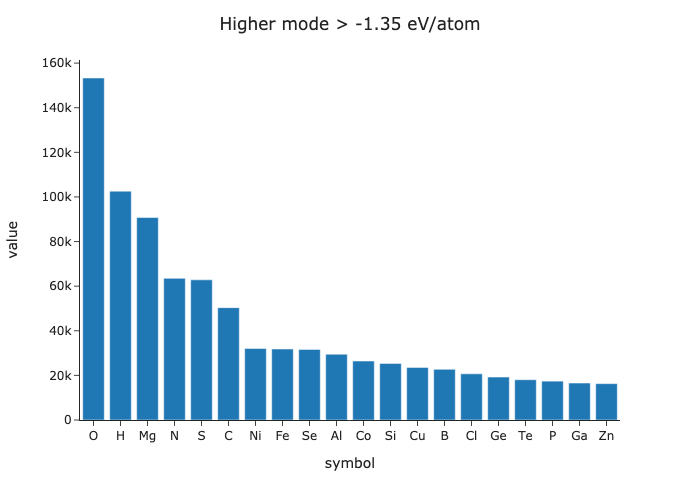

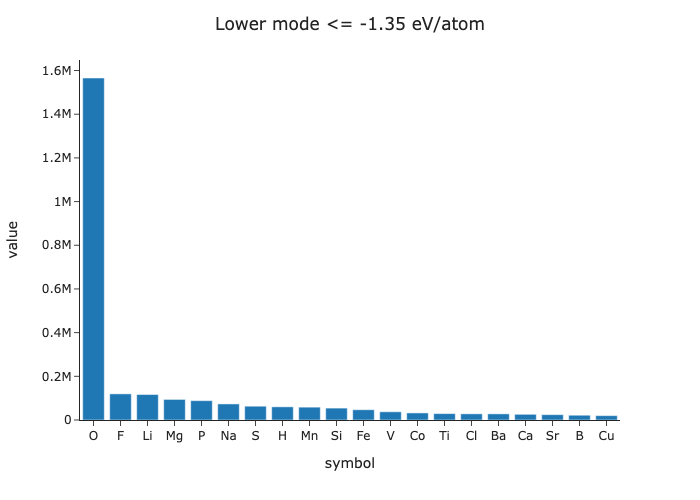

In [ ]:
for comparator, label in ((">", "higher"), ("<=", "lower")):
    sub_formulas = df_e_form_gga_only.query(
        f"formation_energy_per_atom {comparator} {e_form_valley}"
    ).formula
    elem_counts = count_elements(sub_formulas)
    fig = px.bar(elem_counts.nlargest(20))
    title = f"{label.title()} mode {comparator} {e_form_valley} eV/atom"
    fig.update_layout(title=dict(text=title, x=0.5), showlegend=False)
    fig.show()

 This significant lowering of oxide formation energies compared to other anions might at least partially be an artifact of too little experimental data outside oxide systems. In other words, perhaps there should be stronger corrections applied to nitrides, selenides, etc. as well but because there's insufficient experimental data to fit a robust correction scheme there, MP doesn't.